<a href="https://colab.research.google.com/github/fernanda0402/Doutorado/blob/main/Taxa_de_crescimento_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# Bibliotecas:

import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp
import scipy.interpolate as interp
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.optimize import curve_fit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [44]:
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pyccl

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.4.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pyccl']

[+] 0.0s
conda-forge/linux-64  ⣾  
conda-forge/noarch    ⣾  [+] 

In [45]:
import pyccl as ccl

Vamos baixar os dados preditos de $f$.

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
dados_f = np.loadtxt('/content/drive/MyDrive/Doutorado/reconstruction_data.txt')
dados_f

array([[0.        , 0.58125983, 0.66382431, 0.49869535],
       [0.003003  , 0.5823307 , 0.66450321, 0.50015819],
       [0.00600601, 0.58340146, 0.66518405, 0.50161888],
       ...,
       [2.99399399, 1.39723082, 1.74830403, 1.04615761],
       [2.996997  , 1.39763937, 1.74927963, 1.04599912],
       [3.        , 1.3980469 , 1.75025494, 1.04583887]])

Vamos nomear os dados e colunas:

In [48]:
# nomeando dados/colunas

zp = dados_f[:, 0] # o redshift é a primeira coluna
fp = dados_f[:, 1] # f(z) é a segunda coluna
fp_maissigma = dados_f[:, 2] # f + 2 sigma é a terceira coluna
fp_menossigma = dados_f[:, 3] # f - 2 sigma é a quarta coluna

#print(z)

fp_sigma = (fp_maissigma + fp_menossigma)/2

# recorte
mask_zp = zp <= 2.0

Vamos definir a função taxa de crescimento de estruturas a partir do modelo $\Lambda$CDM e plotá-la com os dados preditos de $f$.

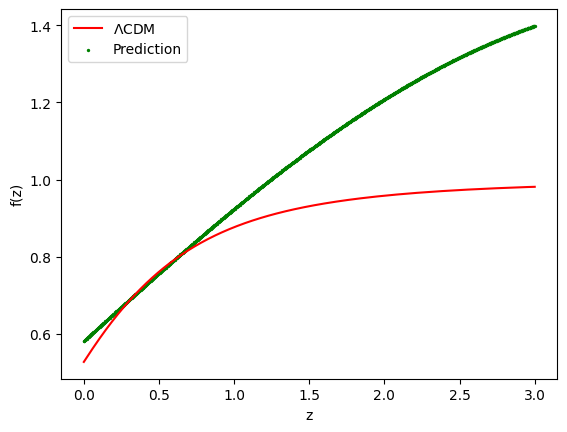

In [49]:
cosmo = ccl.Cosmology(
    Omega_c=0.2656, Omega_b=0.0494, w0 = -1, h=0.6727, sigma8=0.8120, n_s=0.9649) 


a = np.linspace(0.25, 1, 1000)  # fator de escala
delta = ccl.growth_factor(cosmo, a)  # contraste

# definindo o redshift em função do fator de escala
z = (1/a) - 1.

x = np.log(a)
y = np.log(delta)

f = np.gradient(y, x) # função taxa de crescimento


# plote
plt.plot(z, f, color='red', label='$\Lambda$CDM')
plt.scatter(zp, fp, color='green', label='Prediction', s=2)

# legenda, label e título
plt.xlabel('z')
plt.ylabel('f(z)')
plt.legend(loc='best')
plt.show()

Faremos um gráfico com os valores do modelo $\Lambda$CDM com as variações para $\Omega_{m0}$ e $\omega_0$ escolhidas: $\pm$ 0.05 e $\pm$ 0.2, respectivamente.

0.22182350265904513
-1.4758475179113546


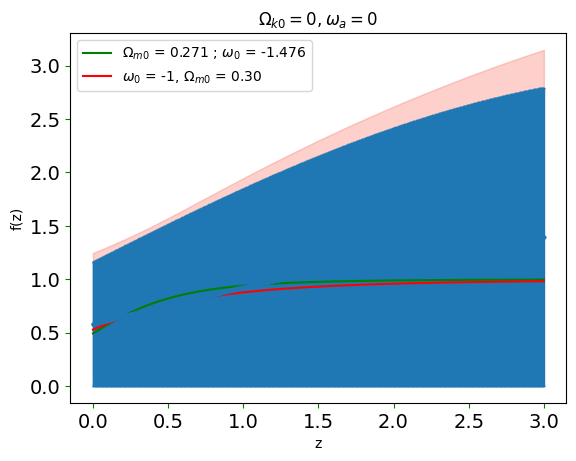

In [50]:
# definindo a função f para o caso de Om e w0 variando

def f1_teorico(z, Om_c, w0):

    cosmo = ccl.Cosmology(Omega_c=Om_c, h=0.6727, Omega_b=0.049411603, Omega_k=0, w0=w0, wa=0, sigma8=0.8120, n_s=0.9649)

    a = 1/(1+z)

    return ccl.background.growth_rate(cosmo, a)

# ajuste da função

popt, pcov = curve_fit(f1_teorico, zp, fp, sigma=fp_sigma, p0=[0.25,-1.2], bounds=([-1.5, -1.5], [1., 1.]), method='trf')
print(popt[0])
print(popt[1])

p1 = popt[0] + 0.049411603
p2 = popt[1]

# plote

#best-fit
zi = np.linspace(min(zp), max(zp), 1000)

fig, ax = plt.subplots()
plt.tick_params(labelsize=14, color='green')
plt.errorbar(zp, fp, yerr = fp_sigma, fmt='o', linestyle="--", markersize=2, elinewidth=1, capsize=1)
plt.plot(zi, f1_teorico(zi, popt[0], popt[1]), color='green', label=r'$\Omega_{m0}$ = '+str(np.round(p1, 3))+' ; '+'$\omega_0$ = '+str(np.round(p2, 3)))

#curvas e dados
ax.plot(z, f, label='$\omega_0$ = -1, $\Omega_{m0}$ = 0.30', color='red')

# área sombreada
ax.fill_between(zp, fp + fp_maissigma, fp - fp_menossigma, alpha=0.2, color='salmon')
ax.fill_between(zp, fp + fp_maissigma, fp -  fp_menossigma, alpha=0.2, color='salmon')

# legenda, título e eixos
plt.legend(loc='best')
plt.xlabel('z')
plt.ylabel('f(z)')
plt.title('$\Omega_{k0} = 0, \omega_a = 0$')
plt.show()

In [ ]:
!pip install derivative
from derivative import dxdt

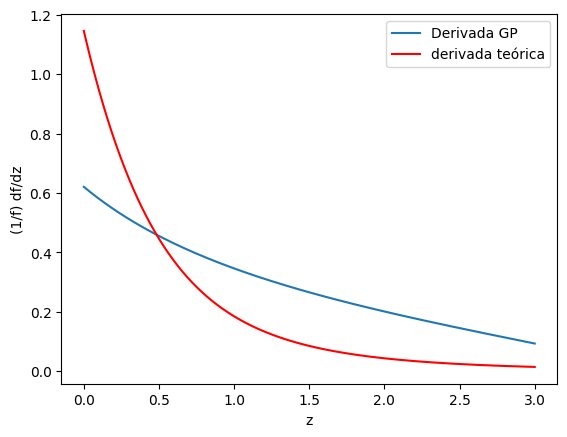

In [52]:
gamma = 6/11
Om0 = 0.30
O_L0 = 1 - Om0

# derivada usando spline

xgp = np.linspace(0,3.0,1000)
ygp = fp

# 4. Spline derivative with smoothing set to 0.01
result_gp = dxdt(ygp, xgp, kind="spline", s=1e-2)
derivada_gp = result_gp/fp

#derivada_gp = np.gradient(fp, zp)/fp

derivada_teo = ( (3 * gamma * O_L0)/( (1+z) * (Om0 * ((1+z)**3) + O_L0) ) ) * f

plt.plot(xgp, derivada_gp, label='Derivada GP')
#plt.errorbar(xgp, derivada_gp, yerr = fp_sigma, fmt='o', color='blue', markersize=2, elinewidth=1, capsize=1)
plt.plot(z, derivada_teo/f, label='derivada teórica', color='red')

# legenda, título e eixos
plt.ylabel('(1/f) df/dz')
plt.xlabel('z')
plt.legend()
plt.show()
plt.show()

In [63]:
# processo de reconstrução usando gaussian process

# dados reais de f
f_dados = np.array([0.56, 0.49, 0.49, 0.60, 0.70, 0.66, 0.70, 0.75, 0.73, 0.91, 0.90])
f_erro = np.array([0.07, 0.14, 0.12, 0.10, 0.18, 0.09, 0.07, 0.18, 0.07, 0.36, 0.24])
z_dados = np.array([0.013, 0.15, 0.18, 0.22, 0.35, 0.38, 0.41, 0.55, 0.60, 0.77, 1.40])


X = z_dados
X = np.atleast_2d(X).T
x = np.atleast_2d(np.linspace(min(z_dados), max(z_dados), 1000)).T
y = f_dados

kernel = C(1.) * RBF(length_scale=1)

gp = GaussianProcessRegressor(kernel=kernel, alpha=f_erro, n_restarts_optimizer=30)

gp.fit(X, y)

f_p, f_psigma = gp.predict(x, return_std=True)

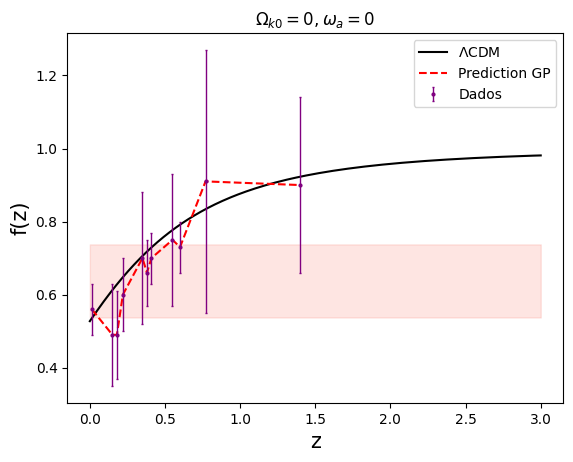

In [70]:
# plote

fig, ax = plt.subplots()
plt.plot(z, f, color='black', label='$\Lambda$CDM')
plt.plot(X, y, color='red', label='Prediction GP', linestyle="--")
#plt.scatter(zp, fp, color='green', s=2)
plt.errorbar(z_dados, f_dados, yerr = f_erro, color = 'purple', label='Dados', fmt='o', markersize=2, elinewidth=1, capsize=1)

# área sombreada
ax.fill_between(zp, f_p + f_psigma, f_p - f_psigma, alpha=0.2, color='salmon')

# legenda, label e título
plt.xlabel('z', fontsize=15)
plt.ylabel('f(z)', fontsize=15)
plt.legend(loc='best')
plt.title('$\Omega_{k0} = 0, \omega_a = 0$')
plt.show()

Vamos tentar usar outro processo gaussiano para a reconstrução da curva de $f(z)$. Este método se encontra no link: https://github.com/JCGoran/GaPP/tree/feature/python3

In [ ]:
!pip install git+https://github.com/JCGoran/GaPP@feature/python3#GaPP
from gapp import gp
from numpy import loadtxt, savetxt

In [74]:
# dados reais de f
f_dados = np.array([0.56, 0.49, 0.49, 0.60, 0.70, 0.66, 0.70, 0.75, 0.73, 0.91, 0.90])
f_erro = np.array([0.07, 0.14, 0.12, 0.10, 0.18, 0.09, 0.07, 0.18, 0.07, 0.36, 0.24])
z_dados = np.array([0.013, 0.15, 0.18, 0.22, 0.35, 0.38, 0.41, 0.55, 0.60, 0.77, 1.40])

# nomeando
x = z_dados
y = z_dados
e = f_erro

xmin = min(x)
xmax = max(y)
nstar = 200

# initial values of the hyperparameters
initheta = [2.0, 2.0]

# initialization of the Gaussian Process
g = gp.GaussianProcess(x, y, e, cXstar=(xmin, xmax, nstar))

# training of the hyperparameters and reconstruction of the function
(rec, theta) = g.gp(theta=initheta)

xi = rec[z_dados]

y_pred = rec[f_dados]
sigma  = rec[f_erro]

y_pred_95_less = y_pred - 1.9600*sigma
y_pred_95_plus = y_pred + 1.9600*sigma

# Plot the function, the prediction and the 95% confidence interval 
plt.figure()
plt.errorbar(x, y, e, fmt='r.', markersize=10, label='Observations')
plt.plot(xi, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([xi, xi[::-1]]),
         np.concatenate([y_pred - 1.9600*sigma,
                        (y_pred + 1.9600*sigma)[::-1]]),
         alpha=0.2, fc='b', ec='None', label='95% confidence interval')

# legenda, label e título
plt.xlabel('z')
plt.ylabel('f(z)')
plt.legend(loc='best')
plt.title('$\Omega_{k0} = 0, \omega_a = 0$')
plt.show()


Optimized hyperparameters:
theta = [1.21887158 1.80764463]


IndexError: ignored